# Calories Burnt Prediction
Tracking and managing caloris burnt during physical activities is essential for maintaining a healthy lifestyle. It's important for individuals to understand how different activities and personal factors influence calorie burn, especially when working towards fitness goals. By utilizing machine learning, we seek to tackle this challenge in health and wellness sectors.


In [8]:
import json
import pickle
import numpy as np



import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [9]:
# The labels
calories_df = pd.read_csv("./datasets/calories.csv")

calories_df

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0
...,...,...
14995,15644082,45.0
14996,17212577,23.0
14997,17271188,75.0
14998,18643037,11.0


In [10]:
# The features
exercise_df = pd.read_csv("./datasets/exercise.csv")

exercise_df

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8
...,...,...,...,...,...,...,...,...
14995,15644082,female,20,193.0,86.0,11.0,92.0,40.4
14996,17212577,female,27,165.0,65.0,6.0,85.0,39.2
14997,17271188,female,43,159.0,58.0,16.0,90.0,40.1
14998,18643037,male,78,193.0,97.0,2.0,84.0,38.3


In [11]:
# I have to join the two dataframes so we can have just one dataframe that contains both the features and their respective labels.

calories_burnt_df = pd.concat([exercise_df, calories_df['Calories']], axis=1)

calories_burnt_df

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0
...,...,...,...,...,...,...,...,...,...
14995,15644082,female,20,193.0,86.0,11.0,92.0,40.4,45.0
14996,17212577,female,27,165.0,65.0,6.0,85.0,39.2,23.0
14997,17271188,female,43,159.0,58.0,16.0,90.0,40.1,75.0
14998,18643037,male,78,193.0,97.0,2.0,84.0,38.3,11.0


<Axes: >

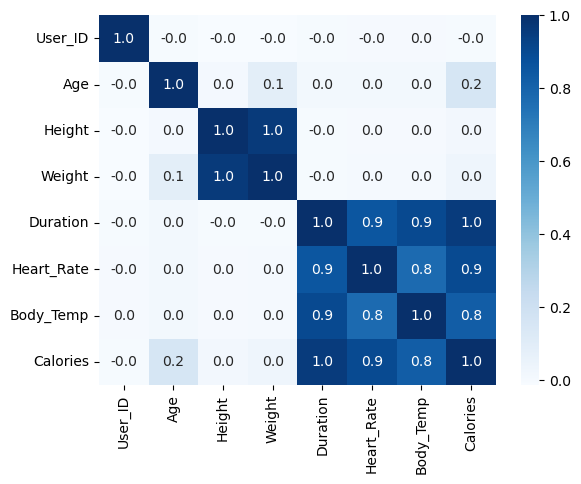

In [12]:
sns.heatmap(
    calories_burnt_df.corr(numeric_only=True),
    cbar=True,
    fmt='.1f',
    annot=True,
    cmap='Blues'
)

In [13]:
# Let's drop the User_ID column since it doesn't really have any relation with our prediction.add()

calories_burnt_df.drop(columns=['User_ID'], axis=1, inplace=True)
calories_burnt_df

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,female,27,154.0,58.0,10.0,81.0,39.8,35.0
...,...,...,...,...,...,...,...,...
14995,female,20,193.0,86.0,11.0,92.0,40.4,45.0
14996,female,27,165.0,65.0,6.0,85.0,39.2,23.0
14997,female,43,159.0,58.0,16.0,90.0,40.1,75.0
14998,male,78,193.0,97.0,2.0,84.0,38.3,11.0


In [14]:
calories_burnt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      15000 non-null  object 
 1   Age         15000 non-null  int64  
 2   Height      15000 non-null  float64
 3   Weight      15000 non-null  float64
 4   Duration    15000 non-null  float64
 5   Heart_Rate  15000 non-null  float64
 6   Body_Temp   15000 non-null  float64
 7   Calories    15000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 937.6+ KB


In [15]:
calories_burnt_df["Gender"].value_counts()

female    7553
male      7447
Name: Gender, dtype: int64

In [16]:
# perform one-hot encoding on the Gender column
calories_burnt_df['Gender'] = calories_burnt_df['Gender'].map(
    {'male': 1, 'female': 0}
)
calories_burnt_df

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,68,190.0,94.0,29.0,105.0,40.8,231.0
1,0,20,166.0,60.0,14.0,94.0,40.3,66.0
2,1,69,179.0,79.0,5.0,88.0,38.7,26.0
3,0,34,179.0,71.0,13.0,100.0,40.5,71.0
4,0,27,154.0,58.0,10.0,81.0,39.8,35.0
...,...,...,...,...,...,...,...,...
14995,0,20,193.0,86.0,11.0,92.0,40.4,45.0
14996,0,27,165.0,65.0,6.0,85.0,39.2,23.0
14997,0,43,159.0,58.0,16.0,90.0,40.1,75.0
14998,1,78,193.0,97.0,2.0,84.0,38.3,11.0


In [17]:
# Also, I noticed that the Weight and Height columns do not have correlations with the calories table individually.add()
# Let's try to see if the BMI of each person would have a good correlation with calories burnt.

# Convert height from cm to m
calories_burnt_df['Height'] = calories_burnt_df['Height'] / 100

# Calculate BMI
calories_burnt_df['BMI'] = calories_burnt_df['Weight'] / (
    calories_burnt_df['Height'] ** 2
)

# Let's visualize how the BMI X Duration will affect calories used:
calories_burnt_df['BMI_x_Duration'] = calories_burnt_df['BMI'] * \
    calories_burnt_df['Duration']


calories_burnt_df

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,BMI_x_Duration
0,1,68,1.90,94.0,29.0,105.0,40.8,231.0,26.038781,755.124654
1,0,20,1.66,60.0,14.0,94.0,40.3,66.0,21.773842,304.833793
2,1,69,1.79,79.0,5.0,88.0,38.7,26.0,24.655910,123.279548
3,0,34,1.79,71.0,13.0,100.0,40.5,71.0,22.159109,288.068412
4,0,27,1.54,58.0,10.0,81.0,39.8,35.0,24.456063,244.560634
...,...,...,...,...,...,...,...,...,...,...
14995,0,20,1.93,86.0,11.0,92.0,40.4,45.0,23.087868,253.966549
14996,0,27,1.65,65.0,6.0,85.0,39.2,23.0,23.875115,143.250689
14997,0,43,1.59,58.0,16.0,90.0,40.1,75.0,22.942130,367.074087
14998,1,78,1.93,97.0,2.0,84.0,38.3,11.0,26.040968,52.081935


In [18]:
# Calculate the correlation matrix
correlation_matrix = calories_burnt_df.corr()

# Extract the correlation between Calories and BMI_x_Duration
calories_bmi_corr = correlation_matrix.loc['Calories', 'BMI_x_Duration']

calories_bmi_corr

0.9559145250881346

- Now we see that I've been able to feature engineer a BMI_x_Duration that has a 0.9 correlation with the Calories column

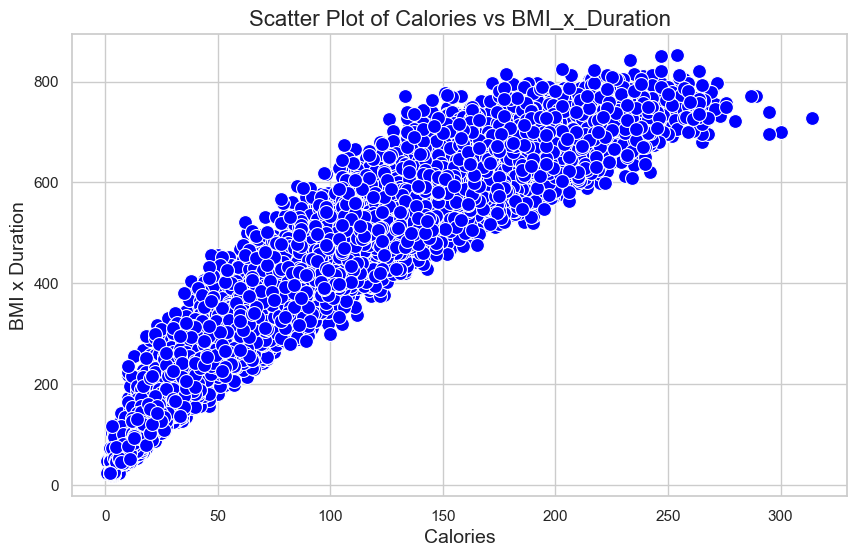

In [19]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=calories_burnt_df, x='Calories',
    y='BMI_x_Duration',s=100, color='blue', marker='o'
)


plt.title('Scatter Plot of Calories vs BMI_x_Duration', fontsize=16)
plt.xlabel('Calories', fontsize=14)
plt.ylabel('BMI x Duration', fontsize=14)

plt.show()

In [20]:
# Let's get a copy of the df to train on
calories_burnt_df_copy = calories_burnt_df.copy()

In [21]:
calories_burnt_df_copy.drop(
    columns=['Height', 'Weight', 'Duration', 'BMI'],
    axis=1,
    inplace=True,
)
calories_burnt_df_copy

,Gender,Age,Heart_Rate,Body_Temp,Calories,BMI_x_Duration
0,1,68,105.0,40.8,231.0,755.124654
1,0,20,94.0,40.3,66.0,304.833793
2,1,69,88.0,38.7,26.0,123.279548
3,0,34,100.0,40.5,71.0,288.068412
4,0,27,81.0,39.8,35.0,244.560634
...,...,...,...,...,...,...
14995,0,20,92.0,40.4,45.0,253.966549
14996,0,27,85.0,39.2,23.0,143.250689
14997,0,43,90.0,40.1,75.0,367.074087
14998,1,78,84.0,38.3,11.0,52.081935


In [22]:
correlation = calories_burnt_df_copy.corr(numeric_only=True)
correlation["Calories"].sort_values(ascending=False)

Calories          1.000000
BMI_x_Duration    0.955915
Heart_Rate        0.897882
Body_Temp         0.824558
Age               0.154395
Gender            0.022357
Name: Calories, dtype: float64

- Let's split the data in way that both males and females are represented well in the test and train sets.

In [23]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(
        calories_burnt_df_copy, calories_burnt_df_copy['Gender']):
    strat_train_set = calories_burnt_df_copy.iloc[train_index]
    strat_test_set = calories_burnt_df_copy.iloc[test_index]

In [24]:
strat_train_set["Gender"].value_counts() / len(strat_train_set)

0    0.5035
1    0.4965
Name: Gender, dtype: float64

In [25]:
strat_test_set["Gender"].value_counts() / len(strat_test_set)

0    0.503667
1    0.496333
Name: Gender, dtype: float64

In [26]:
X_train = strat_train_set.drop(columns=['Calories'], axis=1)
y_train = strat_train_set['Calories']

X_test = strat_test_set.drop(columns=['Calories'], axis=1)
y_test = strat_test_set['Calories']

In [27]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled)
print()
print(X_test_scaled)

[[-0.99302433 -0.16892916 -0.15780285 -0.41218931 -0.57222076]
 [-0.99302433 -0.75560759  1.71832083  0.35400138  0.5870884 ]
 [-0.99302433 -0.16892916 -0.8874065  -0.15679241 -0.9240251 ]
 ...
 [ 1.00702467  0.53508494  1.30140446  0.73709672  1.27499698]
 [-0.99302433 -1.22495032  0.36334262  0.48169983 -0.23216257]
 [ 1.00702467  1.41510258 -1.40855196 -0.9229831  -0.88500037]]

[[-0.99302433  1.47377042 -1.09586469 -1.68917378 -1.5191613 ]
 [ 1.00702467 -0.28626485  0.46757171  0.86479517  0.64613692]
 [-0.99302433 -0.34493269  0.5718008   0.86479517  1.03268605]
 ...
 [-0.99302433  1.18043121  0.46757171  0.73709672  1.36952756]
 [-0.99302433  1.53243826 -0.47049013 -0.53988775 -0.7444966 ]
 [-0.99302433  1.35643474 -0.57471922  0.35400138 -0.05059885]]


## Training and Model Evaluation

- ### Linear Regression

In [28]:
lr_sklearn = LinearRegression()

In [29]:
try:
    lr_sklearn.fit(X_train, y_train)
except ValueError as err:
    print(err)

In [30]:
y_pred = lr_sklearn.predict(X_test)

In [31]:
lr_rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Square Error:", lr_rmse)

Root Mean Square Error: 11.623625255742985


- ### Random Forest Regressor

In [32]:
rf_sklearn = RandomForestRegressor(
    n_estimators=1000,
    random_state=0
)

# Train the model
rf_sklearn.fit(X_train, y_train.ravel())

# Predict the y_value for the test set.
rf_y_pred = rf_sklearn.predict(X_test)

# Calculate the root mean square error.
rf_rmse = mean_squared_error(y_test, rf_y_pred, squared=False)

# The Random forest root mean square error.
print("Random Forest Root Mean Square Error:", rf_rmse)

Random Forest Root Mean Square Error: 5.886504973921283


- ### Decision Tree Regressor

In [33]:
dt_sklearn = DecisionTreeRegressor(random_state=0)

# Train the model
dt_sklearn.fit(X_train, y_train)

# Predict the y_value for the test set.
dt_sklearn_y_pred = dt_sklearn.predict(X_test)

# Calculate the root mean square error.
dt_rmse = mean_squared_error(y_test, dt_sklearn_y_pred, squared=False)

# The Decision Tree root mean square error.
print("Decision Tree Root Mean Square Error:", dt_rmse)

Decision Tree Root Mean Square Error: 8.600290692761495


Compare the RSME for the three different models and rank them according to performance

In [34]:
model_rank = {
    'linear regression': lr_rmse,
    'Random Forest': rf_rmse,
    'Decision Trees': dt_rmse,
}

model_rank = dict(sorted(model_rank.items(), key=lambda item: item[1]))

print(json.dumps(model_rank, indent=4))

{
    "Random Forest": 5.886504973921283,
    "Decision Trees": 8.600290692761495,
    "linear regression": 11.623625255742985
}


In [ ]:
with open("prediction.pkl", "wb") as file:
    pickle.dump(rf_sklearn, file)

print("Best Model saved.")

Best Model saved.


- make prediction with one row in the test_data: Let's make a predicton on the first row

In [36]:
print(X_test.iloc[0])
print()
print("Real Calories Burnt", y_test.iloc[0])

rf_y_pred_first_row = rf_sklearn.predict(X_test.iloc[0:1])
print("Real Calories Burnt", rf_y_pred_first_row[0])

Gender             0.000000
Age               68.000000
Heart_Rate        85.000000
Body_Temp         38.700000
BMI_x_Duration    65.901361
Name: 7259, dtype: float64

Real Calories Burnt 14.0
Real Calories Burnt 13.467


- Draws a scatter plot of the final linear line that fits the dataset after training the linear regression model

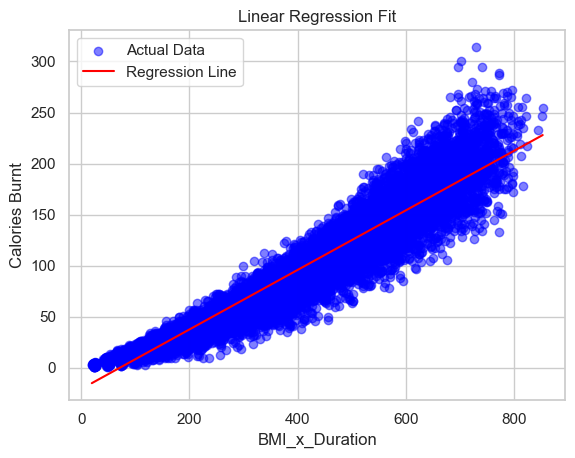

In [37]:
chosen_feature = 'BMI_x_Duration'
X_train_single = X_train[[chosen_feature]]
X_test_single = X_test[[chosen_feature]]

# Train the linear regression model
model = LinearRegression()
model.fit(X_train_single, y_train)

X_range = np.linspace(
    X_train_single.min(),
    X_train_single.max(),
    100
).reshape(-1, 1)

X_range_df = pd.DataFrame(X_range, columns=X_train_single.columns)
y_pred_line = model.predict(X_range_df)


plt.scatter(
    X_train_single,
    y_train,
    color='blue',
    alpha=0.5,
    label='Actual Data'
)

# Regression line
plt.plot(X_range, y_pred_line, color='red', label='Regression Line')

# Add labels and legend
plt.xlabel(chosen_feature)
plt.ylabel('Calories Burnt')
plt.title('Linear Regression Fit')
plt.legend()

plt.show()